In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from transformers import AutoTokenizer, AutoModel
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from accelerate import Accelerator
from PIL import Image
from torch.optim import AdamW

from tqdm.auto import tqdm
import torch.nn.functional as F

import warnings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")

In [4]:
# Создаётся новый класс CustomImageDataset, который наследуется от torch Dataset 
# Наследование позволяет использовать этот класс совместно с DataLoader из PyTorch для эффективной загрузки данных в процессе обучения.

class CustomImageDataset(Dataset):
    def __init__(self, images_dir, tokenizer, prompt, image_size=(256, 256)):
        """
        :param: images_dir: путь к директории с изображениями.
        :param: tokenizer: токенизатор, используемый для преобразования текстовых промптов в токены.
        :param: prompt: текстовый промпт, описывающий стиль или содержание изображений.
        :param: image_size: размер изображений после обработки (по умолчанию (512, 512)).
        """
        self.images_dir = images_dir
        self.image_files = [file for file in os.listdir(images_dir) if file.endswith(('.png', '.jpg'))] # Получение списка файлов изображений
        self.tokenizer = tokenizer
        self.prompt = prompt
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),  # Преобразует изображение в тензор формата [C, H, W]
            transforms.Normalize([0.5], [0.5])  # Нормализация в диапазон [-1, 1]
        ])
    
    def __len__(self):
        """
        Это необходимо для работы DataLoader, чтобы знать, сколько итераций требуется для одной эпохи обучения. 
        :return: Возвращается количество изображений в датасете.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Предоставляет возможность получить образец данных (изображение и соответствующий промпт) по заданному индексу idx.
        Этот метод вызывается при итерировании по датасету в процессе обучения.
        Обеспечивает консистентность входных данных по размеру, формату и диапазону значений пикселей.
        :param idx: 
        :return: Возвращается словарь с обработанными изображением и токенами промпта
        """
        # Загружаем изображение
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Токенизируем промпт
        # Текстовый промпт self.prompt преобразуется в токены с помощью токенизатора self.tokenizer.
        # Модель требует токенизированный текст для понимания того, что нужно сгенерировать. Правильная токенизация гарантирует корректную работу модели.
        encoding = self.tokenizer(
            self.prompt,
            padding="max_length", # добавляет паддинг до максимальной длины модели.
            truncation=True, # обрезает промпт, если он длиннее max_length.
            max_length=self.tokenizer.model_max_length, # станавливает максимальную длину токенов в соответствии с максимальной длиной, поддерживаемой моделью.
            return_tensors="pt"
        )

        return {
            "pixel_values": image, # тензор изображения после всех преобразований.
            "input_ids": encoding.input_ids.squeeze(), # тензор идентификаторов токенов промпта.
            "attention_mask": encoding.attention_mask.squeeze(), # маска внимания для токенов.
        }

In [5]:
model_name = "stabilityai/stable-diffusion-2-base"

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_name, subfolder="tokenizer")

In [6]:
# Определяем уникальный токен
unique_token = "<artg>"

# Добавляем уникальный токен в токенизатор
num_added_tokens = tokenizer.add_tokens(unique_token)

In [ ]:
# Загружаем текстовый энкодер
text_encoder = AutoModel.from_pretrained(model_name, subfolder="text_encoder")

# Обновляем эмбеддинги текстового энкодера
text_encoder.resize_token_embeddings(len(tokenizer))

In [ ]:
# Загружаем VAE-энкодер
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
vae.requires_grad_(False)  # Замораживаем веса VAE
vae.eval()

In [9]:
# Указываем путь к директории с изображениями
images_dir = "data/proc_data"

# Промпт для обучения (включает уникальный токен)
training_prompt = f"A painting in the style of {unique_token}"

# Создаём экземпляр датасета
dataset = CustomImageDataset(images_dir, tokenizer, training_prompt)

# Параметры загрузчика данных
batch_size = 2  # Настройте в соответствии с объёмом видеопамяти
gradient_accumulation_steps = 6  # Настройте в зависимости от данных

# Создаём загрузчик данных
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Используем 0, чтобы избежать проблем с многопроцессорностью на Windows
)

In [10]:
print(f"Пример токенов для prompt: {training_prompt}")
print(f"Токены: {tokenizer(training_prompt)}")


Пример токенов для prompt: A painting in the style of <artg>
Токены: {'input_ids': [49406, 320, 3086, 530, 518, 1844, 539, 49408, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
from diffusers.models.attention_processor import LoRAAttnProcessor
help(LoRAAttnProcessor)
import diffusers
print(diffusers.__version__)


In [ ]:
import diffusers
print("Diffusers version:", diffusers.__version__)
print("Diffusers location:", diffusers.__file__)

In [13]:
# Загружаем модель UNet
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")

# Включаем градиентный чекпоинтинг для UNet
unet.enable_gradient_checkpointing()

# Включаем слайсинг внимания для UNet
unet.set_attn_processor("attn_slicing")

# Определяем ранг для LoRA
lora_rank = 4

# Создаём словарь LoRA процессоров
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    # Проверяем тип внимания
    if name.endswith(".attn1.processor"):
        # Self-Attention
        cross_attention_dim = None
    elif name.endswith(".attn2.processor"):
        # Cross-Attention
        cross_attention_dim = unet.config.cross_attention_dim
    else:
        continue  # Пропускаем другие процессоры

    # Определяем размер скрытого слоя в зависимости от блока
    if "mid_block" in name:
        hidden_size = unet.config.block_out_channels[-1]
    elif "up_blocks" in name:
        block_id = int(name.split('.')[1])
        hidden_size = unet.config.block_out_channels[::-1][block_id]
    elif "down_blocks" in name:
        block_id = int(name.split('.')[1])
        hidden_size = unet.config.block_out_channels[block_id]
    else:
        continue  # Пропускаем, если не удалось определить hidden_size

    # Создаём LoRA процессор
    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=lora_rank
    )

# Устанавливаем LoRA процессоры в модель UNet
unet.set_attn_processor(lora_attn_procs)

# Проверяем, что процессоры установлены
print(f"Установленные процессоры внимания: {set(type(p) for p in unet.attn_processors.values())}")


Установленные процессоры внимания: {<class 'diffusers.models.attention_processor.LoRAAttnProcessor'>}


In [14]:
# Собираем параметры LoRA
lora_parameters = []
for module in unet.attn_processors.values():
    if isinstance(module, LoRAAttnProcessor):
        lora_parameters.extend(module.parameters())

# Проверяем, что параметры были собраны
print(f"Количество параметров LoRA для оптимизации: {len(lora_parameters)}")
assert len(lora_parameters) > 0, "Параметры LoRA не были собраны"

Количество параметров LoRA для оптимизации: 256


In [15]:
# Используем оптимизатор AdamW для параметров LoRA
optimizer = AdamW(lora_parameters, lr=1e-4)

In [16]:
# Инициализируем Accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision="fp16",  # Используем FP16 для экономии памяти
)

# Подготавливаем модели, оптимизатор и загрузчик данных
unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)
text_encoder = accelerator.prepare(text_encoder)
vae = accelerator.prepare(vae)

print(f"Используемое устройство: {accelerator.device}")

Используемое устройство: cuda


In [18]:
unet = unet.to(device)
text_encoder = text_encoder.to(device)

In [20]:
# Количество эпох
num_epochs = 4

# Планировщик шума
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

# Цикл обучения
for epoch in range(num_epochs):
    unet.train()
    print(f"\n--- Начало эпохи {epoch+1}/{num_epochs} ---")
    
    for step, batch in enumerate(tqdm(dataloader, desc=f"Эпоха {epoch+1}")):
        with accelerator.accumulate(unet):
            # Получаем данные и перемещаем на устройство
            pixel_values = batch["pixel_values"].to(accelerator.device)
            input_ids = batch["input_ids"].to(accelerator.device)
            
            # Получаем скрытые состояния из текстового энкодера
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]
            
            # Преобразуем изображения в латентное пространство с помощью VAE
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215  # Масштабируем латенты
            
            # Генерируем случайные таймстемпы для каждого латента
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
    
            # Добавляем шум к латентам
            noise = torch.randn_like(latents)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
    
            # Предсказываем шум с помощью UNet
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
    
            # Вычисляем функцию потерь
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
    
            # Обратное распространение ошибки
            accelerator.backward(loss)
    
            # Обновляем параметры
            optimizer.step()
            optimizer.zero_grad()
    
        # Выводим текущую потерю каждые 10 шагов
        if step % 10 == 0:
            print(f"Эпоха {epoch+1}, Шаг {step}, Потеря: {loss.item()}")
    
    # Сохраняем веса LoRA после каждой эпохи (опционально)
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Сохраняем только веса LoRA
        lora_save_path = f"lora_weights_epoch_{epoch+1}.pt"
        torch.save(accelerator.unwrap_model(unet).state_dict(), lora_save_path)
        print(f"Модель сохранена для эпохи {epoch+1}")

# To fix 1 Warning pip install --upgrade torch
# USE_FLASH_ATTENTION=1 python setup.py install



--- Начало эпохи 1/10 ---


Эпоха 1:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\spark\PycharmProjects\MyFirstPtoject\ArtGenerationLoRA_SD2\.venv\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\spark\PycharmProjects\MyFirstPtoject\ArtGenerationLoRA_SD2\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\spark\PycharmProjects\MyFirstPtoject\ArtGenerationLoRA

Эпоха 1, Шаг 0, Потеря: 0.3724786043167114
Эпоха 1, Шаг 10, Потеря: 0.0967651754617691
Эпоха 1, Шаг 20, Потеря: 0.10034914314746857
Эпоха 1, Шаг 30, Потеря: 0.36180365085601807
Эпоха 1, Шаг 40, Потеря: 0.47463399171829224
Модель сохранена для эпохи 1

--- Начало эпохи 2/10 ---


Эпоха 2:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 2, Шаг 0, Потеря: 0.03078976273536682
Эпоха 2, Шаг 10, Потеря: 0.22905442118644714
Эпоха 2, Шаг 20, Потеря: 0.0032606692984700203
Эпоха 2, Шаг 30, Потеря: 0.12160810828208923
Эпоха 2, Шаг 40, Потеря: 0.03376924991607666
Модель сохранена для эпохи 2

--- Начало эпохи 3/10 ---


Эпоха 3:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 3, Шаг 0, Потеря: 0.014030802994966507
Эпоха 3, Шаг 10, Потеря: 0.02750733308494091
Эпоха 3, Шаг 20, Потеря: 0.05872528254985809
Эпоха 3, Шаг 30, Потеря: 0.1506126970052719
Эпоха 3, Шаг 40, Потеря: 0.008993078023195267
Модель сохранена для эпохи 3

--- Начало эпохи 4/10 ---


Эпоха 4:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 4, Шаг 0, Потеря: 0.004113886039704084
Эпоха 4, Шаг 10, Потеря: 0.3357340693473816
Эпоха 4, Шаг 20, Потеря: 0.0033325720578432083
Эпоха 4, Шаг 30, Потеря: 0.05835406482219696
Эпоха 4, Шаг 40, Потеря: 0.14853747189044952
Модель сохранена для эпохи 4

--- Начало эпохи 5/10 ---


Эпоха 5:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 5, Шаг 0, Потеря: 0.530146598815918
Эпоха 5, Шаг 10, Потеря: 0.21971014142036438
Эпоха 5, Шаг 20, Потеря: 0.33297011256217957
Эпоха 5, Шаг 30, Потеря: 0.02612442336976528
Эпоха 5, Шаг 40, Потеря: 0.055848486721515656
Модель сохранена для эпохи 5

--- Начало эпохи 6/10 ---


Эпоха 6:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 6, Шаг 0, Потеря: 0.021164216101169586
Эпоха 6, Шаг 10, Потеря: 0.005061890929937363
Эпоха 6, Шаг 20, Потеря: 0.32219788432121277
Эпоха 6, Шаг 30, Потеря: 0.05619262158870697
Эпоха 6, Шаг 40, Потеря: 0.5029481649398804
Модель сохранена для эпохи 6

--- Начало эпохи 7/10 ---


Эпоха 7:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 7, Шаг 0, Потеря: 0.009466803632676601
Эпоха 7, Шаг 10, Потеря: 0.003189793322235346
Эпоха 7, Шаг 20, Потеря: 0.11929930001497269
Эпоха 7, Шаг 30, Потеря: 0.36047184467315674
Эпоха 7, Шаг 40, Потеря: 0.22145600616931915
Модель сохранена для эпохи 7

--- Начало эпохи 8/10 ---


Эпоха 8:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 8, Шаг 0, Потеря: 0.4008702039718628
Эпоха 8, Шаг 10, Потеря: 0.2614794969558716
Эпоха 8, Шаг 20, Потеря: 0.021312305703759193
Эпоха 8, Шаг 30, Потеря: 0.10083022713661194
Эпоха 8, Шаг 40, Потеря: 0.11665357649326324
Модель сохранена для эпохи 8

--- Начало эпохи 9/10 ---


Эпоха 9:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 9, Шаг 0, Потеря: 0.006809191778302193
Эпоха 9, Шаг 10, Потеря: 0.018519466742873192
Эпоха 9, Шаг 20, Потеря: 0.49195224046707153
Эпоха 9, Шаг 30, Потеря: 0.037608105689287186
Эпоха 9, Шаг 40, Потеря: 0.2559695839881897
Модель сохранена для эпохи 9

--- Начало эпохи 10/10 ---


Эпоха 10:   0%|          | 0/42 [00:00<?, ?it/s]

Эпоха 10, Шаг 0, Потеря: 0.31905993819236755
Эпоха 10, Шаг 10, Потеря: 0.07281142473220825
Эпоха 10, Шаг 20, Потеря: 0.0032211686484515667
Эпоха 10, Шаг 30, Потеря: 0.023867927491664886
Эпоха 10, Шаг 40, Потеря: 0.04471665620803833
Модель сохранена для эпохи 10


Используемое устройство: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Время генерации: 33.90 секунд


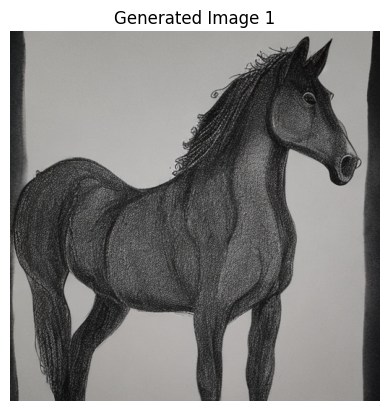

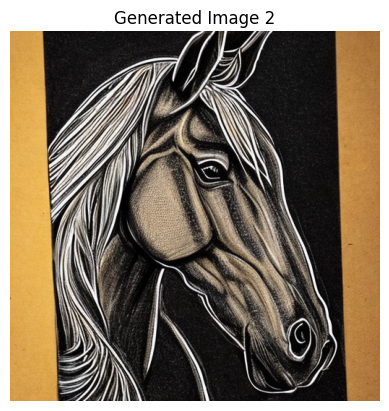

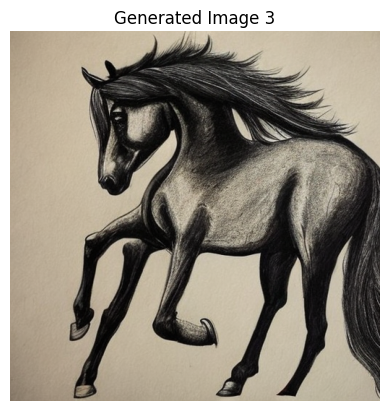

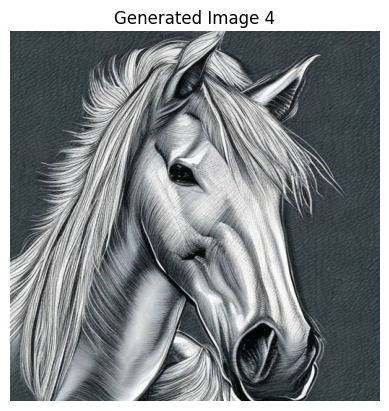

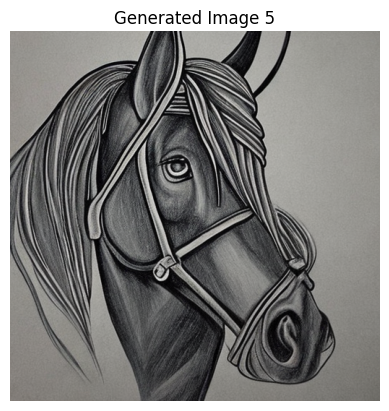

In [25]:
import os
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL
import matplotlib.pyplot as plt
import time

model_name = "stabilityai/stable-diffusion-2-base"
unique_token = "<artg>"
lora_weights_path = "lora_weights_epoch_10.pt"  # Путь к файлу с весами LoRA

# Создаем папку для сохранения результатов, если ее нет
output_folder = "model_results"
os.makedirs(output_folder, exist_ok=True)

# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Очищаем кэш CUDA перед запуском
torch.cuda.empty_cache()

# Загружаем UNet и применяем веса LoRA
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
unet.load_state_dict(torch.load(lora_weights_path, map_location=device, weights_only=True), strict=False)  # Загружаем веса LoRA

# Приводим все параметры UNet к float16 и перемещаем на GPU
unet.to(device).to(torch.float16)

# Загружаем VAE (AutoencoderKL) для работы с латентным пространством и приводим к float16
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device).to(torch.float16)

# Загружаем пайплайн для генерации изображений и заменяем UNet и VAE на модифицированные
pipeline = StableDiffusionPipeline.from_pretrained(
    model_name,
    unet=unet,  # Используем UNet с LoRA весами
    vae=vae,  # Добавляем VAE для работы с латентным пространством
    torch_dtype=torch.float16  # Используем половинную точность для экономии памяти
).to(device)

# Включаем слайсинг внимания
pipeline.enable_attention_slicing()

# Включение выгрузки модели на CPU для экономии памяти
pipeline.enable_model_cpu_offload()

# Промпт для генерации
test_prompt = f"Draw a dark horse with lots of detail. A horse on a dark background. Everything in the style of {unique_token}"

# Увеличиваем разрешение и количество шагов для улучшения качества
image_height = 512  # Увеличьте разрешение
image_width = 512
num_inference_steps = 55  # Увеличьте шаги для лучшего качества

# Замер времени генерации
start_time = time.time()

# Генерация изображения
images = pipeline(
    test_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=7.5,
    height=image_height,
    width=image_width,
    num_images_per_prompt=5  # Генерация 5 изображений
).images

end_time = time.time()
print(f"Время генерации: {end_time - start_time:.2f} секунд")

# Отображаем сгенерированные изображения
for i, image in enumerate(images):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
    plt.show()
